# Analiza projektów kickstarter

## Przygotowanie bibliotek wykorzystywanych w systemie

W systemie wykorzystywane są następujące biblioteki

- **pandas** - odczyt, zapis i operacje na danych
- **datetime** - operacje na datach
- **sklearn** - funkcje wykorzystywane w analizie danych
- **math**, **numpy** - liczne funkcje matematyczne
- **seaborn** - graficzna reprezentacja danych
- **random** - generowanie liczb losowych
- **matplotlib** - wykresy
- **scipy** - metody statystyczne

In [176]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import math
import numpy as np
import seaborn as sns
import random as rand
import matplotlib.pyplot as plt

## Konfiguracja systemu

Ta sekcja zawiera ustawienia dla poszczególnych bibliotek. Są to konfiguracje sposobu wyświetlania danych dla DataFrame oraz kodowania używanego przy wczytywaniu danych z pliku.

In [177]:
# Skonfigurowanie opcji wyświetlania
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

default_figsize = (13, 9)
plt.rcParams["figure.figsize"] = default_figsize

# Parametry wykorzystywane przy wczytywaniu danych
encoding='ISO-8859-1'

## Przygotowanie danych

### Wczytanie danych

In [178]:
dataset_path = './data/kickstarter-projects-filtered.csv'
rows_number = 1000
min_money = 100
max_money = 1000
all_csv_columns = ['main_category', 'currency', 'deadline', 'goal', 'launched', 'pledged', 'state', 'backers', 'country']
df = pd.read_csv(
    dataset_path,
    encoding=encoding,
    low_memory=False
    ).head(rows_number)\
    .filter(all_csv_columns, axis=1)

print(f'max {df["pledged"].max()}')
print(f'min {df["pledged"].min()}')
print(f'mean {df["pledged"].mean()}')
print(f'median {df["pledged"].median()}')
print(df.head())

max 843743.0
min 0.0
mean 8419.58435
median 916.5
  main_category currency        deadline     goal        launched  pledged       state  backers country
0    Publishing      GBP  09-10-15 11:36   1000.0  11-08-15 12:12      0.0      failed        0      GB
1  Film & Video      USD   26-02-13 0:20  45000.0   12-01-13 0:20    220.0      failed        3      US
2         Music      USD   16-04-12 4:24   5000.0   17-03-12 3:24      1.0      failed        1      US
3          Food      USD  01-04-16 13:38  50000.0  26-02-16 13:38  52375.0  successful      224      US
4          Food      USD  21-12-14 18:30   1000.0  01-12-14 18:30   1205.0  successful       16      US


### Konwersja danych tekstowych na dane liczbowe

Aby dane mogły zostać poprawnie przetworzone w dalszych krokach przy użyciu metody PCA, dane tekstowe należy zamienić na dane liczbowe. Do tego celu można wykorzystać słowniki. Algorytm konwersji jest następujący:
- zebrać wszystkie wartości występujące w danej kolumnie
- przyporządkować każdej wartości kolejną liczbę naturalną rozpoczynając od zera (lub jedynki).

In [179]:
def get_all_values_from_column(df, col_name):
    values = []
    for i in df[col_name].index:
        category = df[col_name][i]
        if category not in values:
            values.append(category)

    return values


def create_label_number_dict(names, start_from_zero = True):
    normalized = {}
    zero_margin = 1 - int(start_from_zero)
    for i in range(0, len(names)):
        name = names[i]
        normalized[name] = i + zero_margin

    return normalized

def map_text_to_number(df, column_name, dict):
    mapped = pd.Series(df[column_name].map(dict), name=column_name)
    df.update(mapped)

    return df

In [180]:
categories = get_all_values_from_column(df, 'main_category')
countries = get_all_values_from_column(df, 'country')
states = get_all_values_from_column(df, 'state')
currencies = get_all_values_from_column(df, 'currency')

categories_dict = create_label_number_dict(categories)
countries_dict = create_label_number_dict(countries)
states_dict = { 'failed': 0, 'successful': 1 }
currencies_dict = create_label_number_dict(currencies)

df = map_text_to_number(df, 'main_category', categories_dict)
df = map_text_to_number(df, 'country', countries_dict)
df = map_text_to_number(df, 'state', states_dict)
df = map_text_to_number(df, 'currency', currencies_dict)

### Konwersja dat na dane liczbowe

W przypadku dat przyjęto strategię reprezentacji ich jako roku

In [181]:
def date_to_timestamp(dt):
    return datetime.strptime(dt, "%d-%m-%y %H:%M").year


def map_date_to_timestamp(df, column_names):
    for column_name in column_names:
        mapped = pd.Series(df[column_name].map(date_to_timestamp), name=column_name)
        df.update(mapped)

    return df

df = map_date_to_timestamp(df, ['launched', 'deadline'])

In [182]:
# columns_to_normalize = ['main_category','currency', 'country', 'deadline', 'goal', 'launched', 'pledged', 'state', 'backers']
# df[columns_to_normalize] = df[columns_to_normalize].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
# df.head()

x = df
quantile = QuantileTransformer()
X = quantile.fit_transform(x)
df = quantile.transform(X)
df = pd.DataFrame(X)
df.columns = all_csv_columns
df.head()

C:\Users\Hubert\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


,main_category,currency,deadline,goal,launched,pledged,state,backers,country
0,0.000000,0.000000,0.735235,0.169670,0.746747,0.000000,0.0,0.000000,0.000000
1,0.186186,0.508509,0.329830,0.905405,0.337337,0.360360,0.0,0.278278,0.508509
2,0.361862,0.508509,0.176677,0.514014,0.184184,0.139139,0.0,0.165165,0.508509
3,0.471972,0.508509,1.000000,0.918418,1.000000,0.970971,1.0,0.916917,0.508509
4,0.471972,0.508509,0.522022,0.169670,0.529530,0.549049,1.0,0.483483,0.508509


Dla poprawności dalszych kroków można sprawdzić, czy któreś kolumny nie zawierają niepoprawnych/pustych danych

In [183]:
is_any_nan = False
for column in all_csv_columns:
    is_any_nan = is_any_nan or df[column].isnull().values.any()

print(f'\nCzy istnieją nieprawidłowe wartości w zbiorze danych: {is_any_nan}\n')


Czy istnieją nieprawidłowe wartości w zbiorze danych: False



## Podział zbioru na dane uczące i dane testowe

Do stworzenia systemu potrzebne są zarówno dane uczące --- te, z których algorytmy będą czerpały informacje o zależnościach, jak i dane testowe, wykorzystywane do sprawdzenia poprawności zaimplementowanych algorytmów. Podziału dokonano w stosunku 90/10

In [184]:
train_to_test_ratio = 0.1
df_train, df_test = train_test_split(df, test_size=train_to_test_ratio)

## Analiza PCA

### Wybór ilości kolumn

Analiza PCA pozwala oszacować jaką skuteczność będzie miał system dla danej ilości kolumn. Takie oszacowanie może być bardzo pomocne w wyborze optymalnej ilości kolumn. Jeżeli na podstawie posiadanych danych jesteśmy w stanie stworzyć system, który będzie cechował się skutecznością na poziomie 90% już dla 3 kolumn, to być może jest to wartość wystarczająca, zakładając, że na przykład dla 8 kolumn system będzie miał 93% skuteczności. Wtedy należy rozważyć, czy dodatkowa złożoność wynikająca z uwzględnienia większej ilości kolumn jest warta uzyskania dodatkowych 3 punktów procentowych skuteczności.

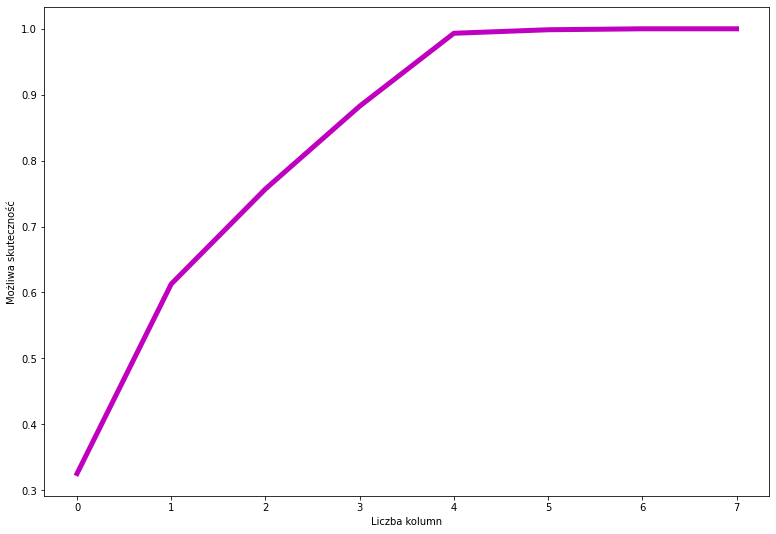

In [185]:
all_columns = [
    'currency',
    'country',
    'state',
    'pledged',
    'backers',
    'goal',
    'main_category',
    'launched',
    'deadline',
]

all_features_columns = [
    'currency',
    'country',
    'pledged',
    'backers',
    'goal',
    'main_category',
    'launched',
    'deadline',
]

labels_columns = ['state']

features = df_train[all_features_columns]
labels = df_train[labels_columns]

pca = PCA().fit(features, labels)
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'm', linewidth=5.0)
plt.xlabel('Liczba kolumn')
plt.ylabel('Możliwa skuteczność')
plt.show()

Na powyższym wykresie można zauważyć, że już dla 3 kolumn można osiągnąć maksymalną skuteczność, więc analizowanie większej ilości kolumn nie jest potrzebne. Co więcej, mogłoby to wprowadzić dodatkowy poziom złożoności i niepotrzebną konieczność wykonywania obliczeń i analiz.

### Wybór kolumn do dalszej analizy

W celu wybrania kolumn mających największy wpływ na przynależność do klasy można posłużyć się macierzą kowariancji. Na jej podstawie możliwe będzie stworzenie mapy ciepła, która w przejrzysty sposób zobrazuje zależności między poszczególnymi kolumnami

#### Stworzenie macierzy kowariancji i wygenerowanie heatmapy

0: currency
1: country
2: state
3: pledged
4: backers
5: goal
6: main_category
7: launched
8: deadline


<AxesSubplot:>

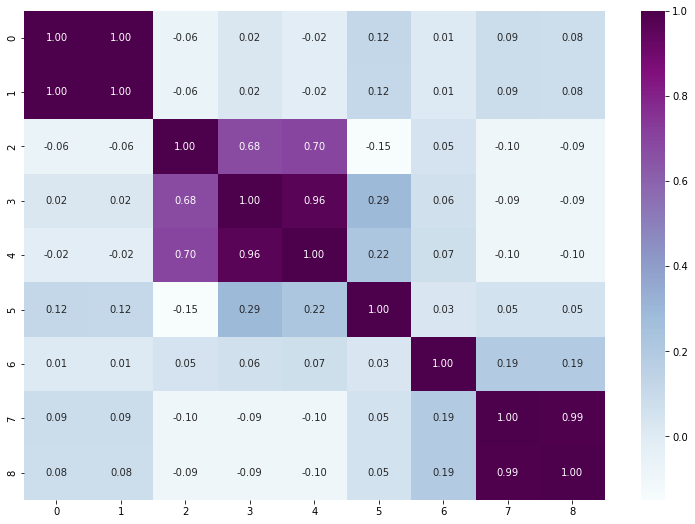

In [186]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_train[all_columns])

covariance_matrix = np.cov(features_scaled.T)

columns_dict = create_label_number_dict(all_columns, True)
for column in all_columns:
    print(f'{columns_dict[column]}: {column}')

fig, ax = plt.subplots(figsize=default_figsize)         # Sample figsize in inches
sns.heatmap(covariance_matrix, annot=True, ax=ax, fmt='0.2f', cmap='BuPu')

Kolumną decyzyjną jest kolumna numer 2 - jest to kolumna mówiąca o tym, czy projekt zakończył się porażką (1) czy sukcesem (2). Z mapy ciepła wynika korelacja następujących 3 kolumn z kolumną decyzyjną:

|  Kolumna 1  |  Kolumna 2  | Kolumna 3 |
|:-----------:|:-----------:|:---------:|
| pledged (3) | backers (4) | goal (5)  |

Na mapie widać inne mocne korelacje, np.:
  - 8 i 9 (_launched_ i _deadline_) - kolumny traktujące o dacie rozpoczęcia i zakończenia zbiórki,
  - 1 i 2 (_currency_ i _country_) - waluta i kraj
  - 4 i 5 (_pledged_ i _backers_) - zebrana kwota i ilość wspierających

Powyższe korelacje, mimo że są wysokie, nie wnoszą nic do analizowanego przykładu.

Dla większego zbioru danych zbioru (dla pełnego zakresu stawianych celów, nie tylko z przedziału 100 - 1000 USD) dało się zauważyć, że rośnie wpływ daty założenia zbiórki na jego powodzenie. Być może świadczy to o tym, że wysokobudżetowe projekty mające większy wpływ na rozwój (technologii, cywilizacji, być może jakieś przełomowe odkrycie) w większym stopniu zależą od czasu, w jakim są rozwijane aniżeli mniejsze, hobbystyczne projekty.

In [187]:
selected_features = ['pledged', 'backers', 'goal']

#### Uzasadnienie wyboru kolumn

Patrząc na charakterystykę wybranych kolumn, można stwierdzić następujące zależności:
  1. Kolumna **pledged** - ilość zgromadzonych środków
  2. Kolumna **backers** - ilość osób wspierających
  3. Kolumna **launched** - rok rozpoczęcia zbiórki

Pierwsze 2 kolumny mają oczywisty wpływ na powodzenie projektu, ponieważ im więcej środków zostanie zebranych, tym większa szansa na jego powodzenie. Na ilość środków wpływa z kolei ilość osób wspierających, ponieważ z reguły większa grupa osób jest w stanie zebrać więcej środków niż mniejsza grupa.

Wobec tego do dalszej analizy będziemy używać tylko wybranych kolumn.

## KNN

### Model pojedynczego elementu

In [188]:
class Startup:
    def __init__(self, dataframe_row):
        self.pledged = dataframe_row['pledged']
        self.backers = dataframe_row['backers']
        self.goal = dataframe_row['goal']
        self.state = dataframe_row['state']

    def get_distance_from(self, startup):
        return math.sqrt(
            math.pow(self.pledged - startup.pledged, 2)
            + math.pow(self.backers - startup.backers, 2)
            + math.pow(self.goal - startup.goal, 2)
        )

    def to_string(self):
        return f'pledged: {self.pledged}, backers: {self.backers}, goal: {self.goal}, state: {self.state}'

### Model klasy bazowej

In [189]:
class KnnBase:
    def __init__(self, df):
        self.df = df
        self.count = df['state'].count()
        self.items_objects = self.create_startups_objects(df)

    def create_startups_objects(self, df, clear_state=False):
        count = df['state'].count()
        objects = []
        for i in range(0, count):
            obj = Startup(df.iloc[i])
            if clear_state:
                obj.state = None
            objects.append(obj)
        return objects

## KNN

In [190]:
class Knn(KnnBase):
    def __init__(self, df):
        super().__init__(df)

    def classify(self, unknown, k, print_details=True):
        measured_distances = []
        k_closest = []

        # Calculate distances
        for i in range(0, len(self.items_objects)):
            startup = self.items_objects[i]
            distance = startup.get_distance_from(unknown)
            measured_distances.append({ 'index': i, 'distance': distance, 'class': startup.state })

        # Sort by lower distance
        measured_distances = sorted(measured_distances, key=lambda item: item['distance'])

        # Select the k closest neighbours
        for i in range(0, k):
            k_closest.append(measured_distances[i])

        dominant_class = self.get_dominant_class(k_closest)
        if print_details:
            self.print_selected_closest_neighbours(k_closest)
            print(f'Na podstawie {k} najbliższych sąsiadów, element należy do klasy {dominant_class}')

        return dominant_class

    def get_dominant_class(self, closest):
        classes_dict = {}
        for el in closest:
            class_name = el["class"]
            if class_name not in classes_dict.keys():
                classes_dict[class_name] = 0
            current_class_count_value = int(classes_dict.get(class_name))
            classes_dict[class_name] = current_class_count_value + 1

        return max(classes_dict, key=classes_dict.get)



    def get_all_classes(self, closest):
        classes = []
        for el in closest:
            new_class = el['class']
            if new_class not in classes:
                classes.append(el['class'])
        return classes

    def print_selected_closest_neighbours(self, closest):
        print(f'{len(closest)} najbliższych sąsiadów elementu')
        lp = 1
        for neighbour in closest:
            print(f'  {lp}. Dystans: {neighbour["distance"]} klasa:{neighbour["class"]}')
            lp += 1

### Metryki dla klasyfikacji KNN

Metryki dają informacje w postaci następujących wielkości:
  - **precision** - zdolność klasyfikatora do nieoznaczenia próbki negatywnej jako pozytywnej
  - **recall** - zdolnośc klasyfikatora do znalezienia wszystkich pozytywnych próbek
  - **f1-score** - ważona średnia harmoniczna wartości **precision** i **recall**
  - **support** - ilość próbek

In [191]:
knn_k_means = Knn(df_train)

test_data_size = df_test['state'].count()
classified_correctly = 0

expected_classes = []
predicted_classes = []

for i in range(0, test_data_size):
    new_object = Startup(df_test.iloc[i])
    expected_outcome = new_object.state
    predicted_outcome = knn_k_means.classify(new_object, 7, False)

    expected_classes.append(expected_outcome)
    predicted_classes.append(predicted_outcome)

    if predicted_outcome == expected_outcome:
        classified_correctly += 1

              precision    recall  f1-score   support

  successful       1.00      0.98      0.99        65
      failed       0.97      1.00      0.99        35

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



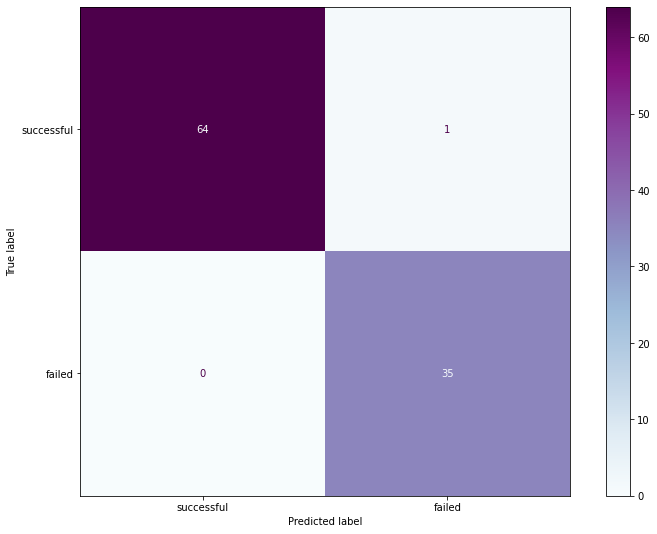

In [192]:
print(classification_report(expected_classes, predicted_classes, target_names=['successful', 'failed']))

disp = ConfusionMatrixDisplay.from_predictions(expected_classes, predicted_classes, display_labels=['successful', 'failed'], cmap=plt.cm.BuPu)
plt.show()

## KNN - Centroidy

In [193]:
class KnnCentroids(KnnBase):
    def __init__(self, df):
        super().__init__(df)
        self.clusters = []
        self.create_startups_objects(df, True)
        self.generate_random_clusters()

    def train(self):
        points_changed = self.match_point_to_clusters()
        counter = 0
        while points_changed and counter < 1000000:
            counter += 1
            self.reposition_clusters()
            points_changed = self.match_point_to_clusters()

    def generate_random_clusters(self):
        clusters =  []
        for i in [0, 1]:
            pledged = rand.uniform(self.df['pledged'].min(), self.df['pledged'].max())
            state = i
            backers = rand.uniform(self.df['backers'].min(), self.df['backers'].max())
            goal = rand.uniform(self.df['goal'].min(), self.df['goal'].max())
            clusters.append(
                Startup(pd.Series({
                    'pledged': pledged,
                    'backers': backers,
                    'goal': goal,
                    'state': state,
                }))
            )

        self.clusters = clusters

    def reposition_clusters(self):
        for cluster in self.clusters:
            pledged_sum = 0
            backers_sum = 0
            pledged_ratio_sum = 0
            count = 0

            for item in self.items_objects:
                if item.state == cluster.state:
                    pledged_sum += item.pledged
                    backers_sum += item.backers
                    pledged_ratio_sum += item.goal
                    count += 1

            if count > 0:
                cluster.pledged = pledged_sum / count
                cluster.backers = backers_sum / count
                cluster.goal = pledged_ratio_sum / count

    def match_point_to_clusters(self):
        changed = 0
        for item in self.items_objects:
            current_state = item.state
            best_distance = None

            for cluster in self.clusters:
                if best_distance is None:
                    best_distance = item.get_distance_from(cluster)
                    new_state = cluster.state
                else:
                    new_distance = item.get_distance_from(cluster)
                    if new_distance < best_distance:
                        best_distance = new_distance
                        new_state = cluster.state

            if current_state != new_state:
                item.state = new_state
                changed += 1
        return changed

    def classify(self, item, print_result=True):
        distance = None
        item_class = None
        for cluster in self.clusters:
            new_distance = item.get_distance_from(cluster)
            new_item_class = cluster.state

            if distance is None:
                distance = new_distance
            if item_class is None:
                item_class = new_item_class
            if distance is not None and distance < new_distance:
                item_class = new_item_class
        if print_result:
            print(f'Element sklasyfikowany jako {item_class}')

        return item_class

### Metryki klasyfikacji KNN dla centroidów

In [194]:
knn_centroids = KnnCentroids(df_train)
knn_centroids.train()

test_data_size = df_test['state'].count()
classified_correctly = 0

expected_classes = []
predicted_classes = []

for i in range(0, test_data_size):
    new_object = Startup(df_test.iloc[i])
    expected_outcome = new_object.state
    predicted_outcome = knn_centroids.classify(new_object, False)

    expected_classes.append(expected_outcome)
    predicted_classes.append(predicted_outcome)

    if predicted_outcome == expected_outcome:
        classified_correctly += 1

              precision    recall  f1-score   support

  successful       0.89      0.78      0.84        65
      failed       0.67      0.83      0.74        35

    accuracy                           0.80       100
   macro avg       0.78      0.81      0.79       100
weighted avg       0.82      0.80      0.80       100



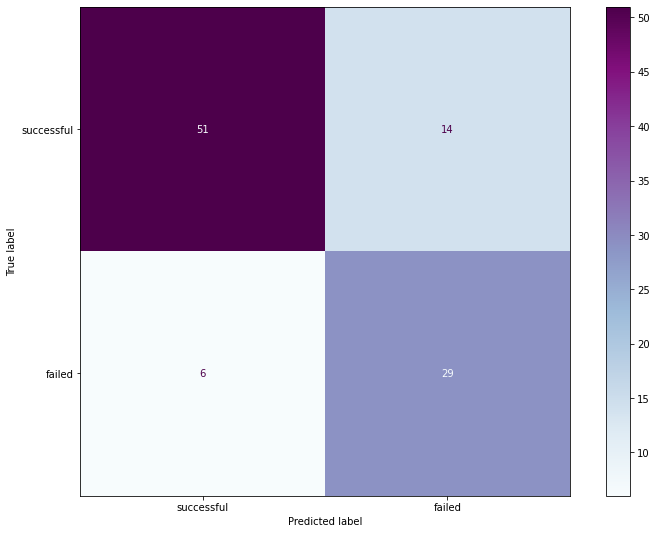

In [195]:
print(classification_report(expected_classes, predicted_classes, target_names=['successful', 'failed']))

disp = ConfusionMatrixDisplay.from_predictions(expected_classes, predicted_classes, display_labels=['successful', 'failed'], cmap=plt.cm.BuPu)
plt.show()

## Zbiory rozmyte

In [223]:
def gauss(x, avg, std):
    return np.exp(-(x - avg)**2 / (2 * std**2))

In [224]:
pledged_range = sorted(df_train.query('0.0 < pledged < 1.0')['pledged'])
pledged_1 = sorted(df_train.query('0.0 <= pledged < 0.3')['pledged'])
pledged_2 = sorted(df_train.query('0.3 <= pledged < 0.6')['pledged'])
pledged_3 = sorted(df_train.query('0.6 <= pledged < 1.0')['pledged'])

backers_range = sorted(df_train.query('0.0 < backers < 1.0')['backers'])
backers_1 = sorted(df_train.query('0.0 <= backers < 0.3')['backers'])
backers_2 = sorted(df_train.query('0.3 <= backers < 0.7')['backers'])
backers_3 = sorted(df_train.query('0.7 <= backers < 1.0')['backers'])

goal_range = sorted(df_train.query('0.0 < goal < 1.0')['goal'])
goal_1 = sorted(df_train.query('0.0 <= goal < 0.4')['goal'])
goal_2 = sorted(df_train.query('0.4 <= goal < 0.7')['goal'])
goal_3 = sorted(df_train.query('0.7 <= goal < 1')['goal'])

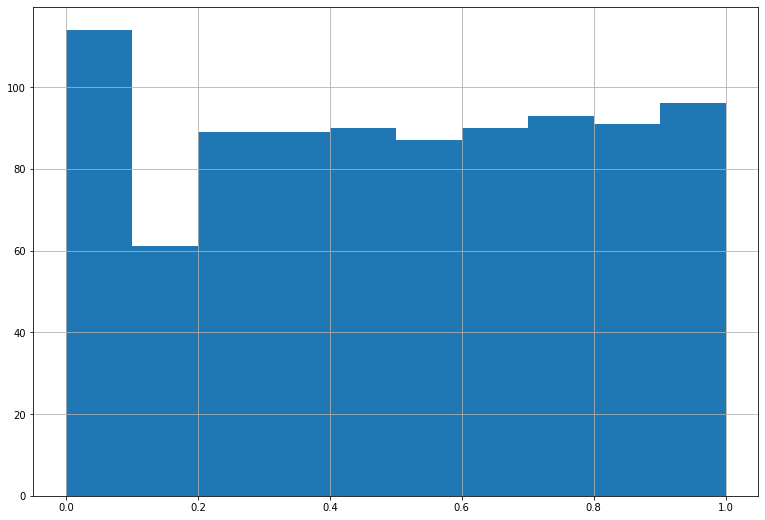

In [225]:
df_train['pledged'].hist()
plt.show()

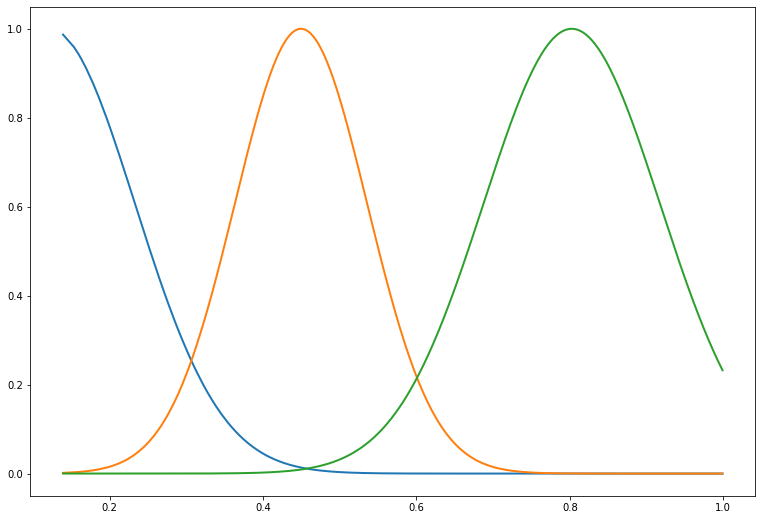

In [226]:
plt.plot(pledged_range, gauss(pledged_range, np.mean(pledged_1), np.std(pledged_1)), linewidth=2)
plt.plot(pledged_range, gauss(pledged_range, np.mean(pledged_2), np.std(pledged_2)), linewidth=2)
plt.plot(pledged_range, gauss(pledged_range, np.mean(pledged_3), np.std(pledged_3)), linewidth=2)
plt.show()

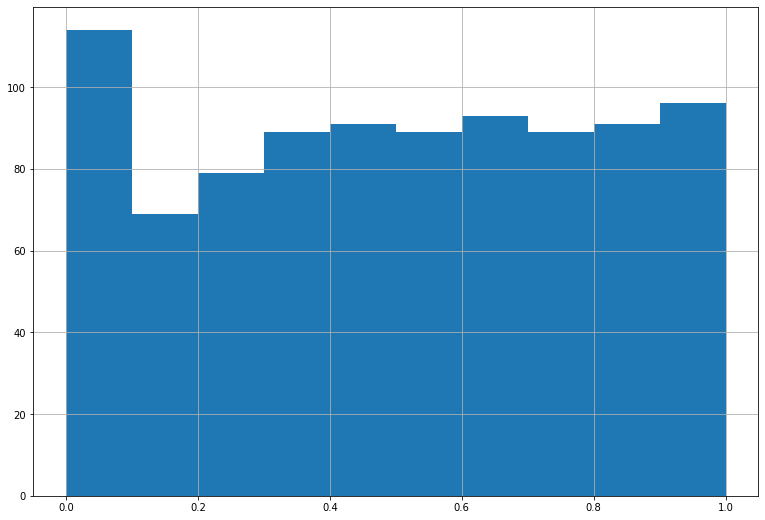

In [227]:
df_train['backers'].hist()
plt.show()

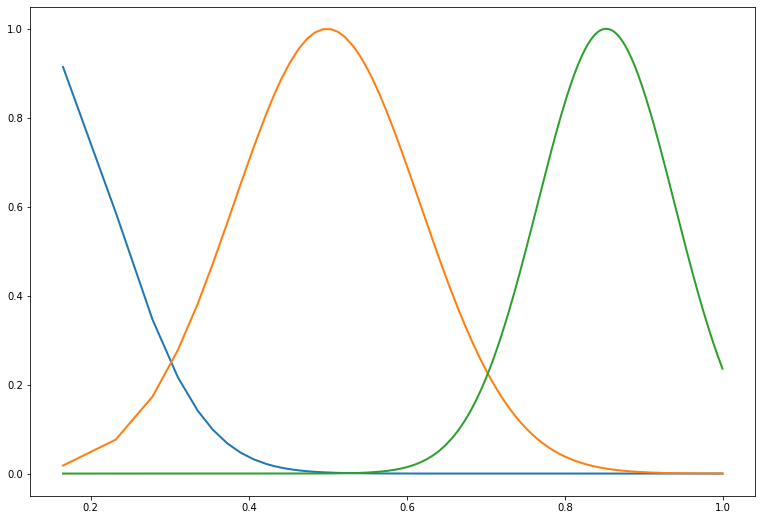

In [228]:
plt.plot(backers_range, gauss(backers_range, np.mean(backers_1), np.std(backers_1)), linewidth=2)
plt.plot(backers_range, gauss(backers_range, np.mean(backers_2), np.std(backers_2)), linewidth=2)
plt.plot(backers_range, gauss(backers_range, np.mean(backers_3), np.std(backers_3)), linewidth=2)
plt.show()

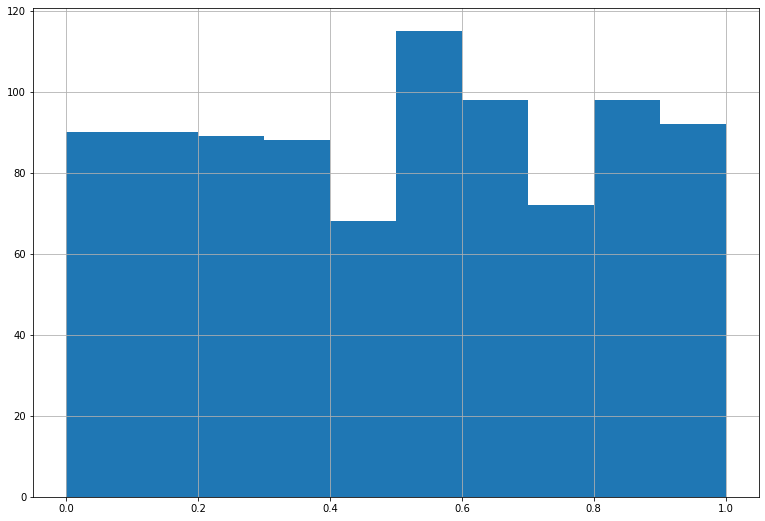

In [229]:
df_train['goal'].hist()
plt.show()

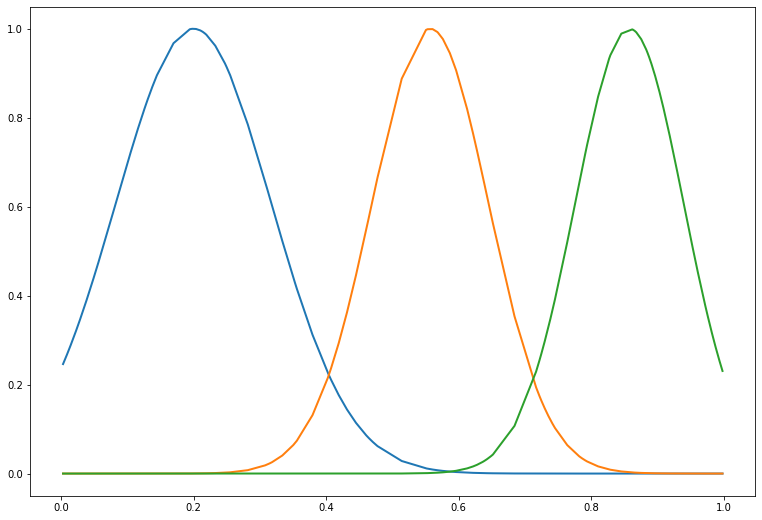

In [230]:
plt.plot(goal_range, gauss(goal_range, np.mean(goal_1), np.std(goal_1)), linewidth=2)
plt.plot(goal_range, gauss(goal_range, np.mean(goal_2), np.std(goal_2)), linewidth=2)
plt.plot(goal_range, gauss(goal_range, np.mean(goal_3), np.std(goal_3)), linewidth=2)
plt.show()

### Funkcje przynależności


In [232]:
class Pledged:
    @staticmethod
    def is_low(value):
        return gauss(value, np.mean(pledged_1), np.std(pledged_1))
    @staticmethod
    def is_medium(value):
        return gauss(value, np.mean(pledged_2), np.std(pledged_2))
    @staticmethod
    def is_high(value):
        return gauss(value, np.mean(pledged_3), np.std(pledged_3))


class Backers:
    @staticmethod
    def is_low(value):
        return gauss(value, np.mean(backers_1), np.std(backers_1))
    @staticmethod
    def is_medium(value):
        return gauss(value, np.mean(backers_2), np.std(backers_2))
    @staticmethod
    def is_high(value):
        return gauss(value, np.mean(backers_3), np.std(backers_3))


class Goal:
    @staticmethod
    def is_low(value):
        return gauss(value, np.mean(goal_1), np.std(goal_1))
    @staticmethod
    def is_medium(value):
        return gauss(value, np.mean(goal_2), np.std(goal_2))
    @staticmethod
    def is_high(value):
        return gauss(value, np.mean(goal_3), np.std(goal_3))

### Definicja reguł

In [276]:
def rules(pledged, backers, goal):
  fuzzy_rules = [
    (Pledged.is_low(pledged) * Backers.is_low(backers) * Goal.is_low(goal)),
    (Pledged.is_low(pledged) * Backers.is_low(backers) * Goal.is_medium(goal)),
    (Pledged.is_low(pledged) * Backers.is_low(backers) * Goal.is_high(goal)),
    (Pledged.is_low(pledged) * Backers.is_medium(backers) * Goal.is_low(goal)),
    (Pledged.is_low(pledged) * Backers.is_medium(backers) * Goal.is_medium(goal)),
    (Pledged.is_low(pledged) * Backers.is_medium(backers) * Goal.is_high(goal)),
    (Pledged.is_low(pledged) * Backers.is_high(backers) * Goal.is_low(goal)),
    (Pledged.is_low(pledged) * Backers.is_high(backers) * Goal.is_medium(goal)),
    (Pledged.is_low(pledged) * Backers.is_high(backers) * Goal.is_high(goal)),

    (Pledged.is_medium(pledged) * Backers.is_low(backers) * Goal.is_low(goal)),
    (Pledged.is_medium(pledged) * Backers.is_low(backers) * Goal.is_medium(goal)),
    (Pledged.is_medium(pledged) * Backers.is_low(backers) * Goal.is_high(goal)),
    (Pledged.is_medium(pledged) * Backers.is_medium(backers) * Goal.is_low(goal)),
    (Pledged.is_medium(pledged) * Backers.is_medium(backers) * Goal.is_medium(goal)),
    (Pledged.is_medium(pledged) * Backers.is_medium(backers) * Goal.is_high(goal)),
    (Pledged.is_medium(pledged) * Backers.is_high(backers) * Goal.is_low(goal)),
    (Pledged.is_medium(pledged) * Backers.is_high(backers) * Goal.is_medium(goal)),
    (Pledged.is_medium(pledged) * Backers.is_high(backers) * Goal.is_high(goal)),

    (Pledged.is_high(pledged) * Backers.is_low(backers) * Goal.is_low(goal)),
    (Pledged.is_high(pledged) * Backers.is_low(backers) * Goal.is_medium(goal)),
    (Pledged.is_high(pledged) * Backers.is_low(backers) * Goal.is_high(goal)),
    (Pledged.is_high(pledged) * Backers.is_medium(backers) * Goal.is_low(goal)),
    (Pledged.is_high(pledged) * Backers.is_medium(backers) * Goal.is_medium(goal)),
    (Pledged.is_high(pledged) * Backers.is_medium(backers) * Goal.is_high(goal)),
    (Pledged.is_high(pledged) * Backers.is_high(backers) * Goal.is_low(goal)),
    (Pledged.is_high(pledged) * Backers.is_high(backers) * Goal.is_medium(goal)),
    (Pledged.is_high(pledged) * Backers.is_high(backers) * Goal.is_high(goal)),
  ]

  decisions = [
    1,0,0,0,0,0,
    0,0,1,0,0,
    0,1,0,0,0,1,0
  ]

  failed = []
  successful = []

  for i in range(0, len(decisions)):
    if decisions[i] == 0:
      failed.append(fuzzy_rules[i])
    else:
      successful.append(fuzzy_rules[i])

  # Mapowanie na numery decyzji
  return {
      "Max_0": max(failed),
      "Index_0": fuzzy_rules.index(max(failed)),
      # "Max_1": max(successful),
      # "Index_1": fuzzy_rules.index(max(successful)),
  }

In [277]:
results = []

for index in df_test.index:
    row = df_test.loc[index]
    value = rules(row['pledged'], row['backers'], row['goal'])
    results.append({
      'value': value,
      'decision': row['state']
  })

results

[{'value': {'Max_0': 0.17972240475591122, 'Index_0': 13}, 'decision': 0.0},
 {'value': {'Max_0': 0.14578322791412723, 'Index_0': 1}, 'decision': 0.0},
 {'value': {'Max_0': 0.180777011231614, 'Index_0': 1}, 'decision': 0.0},
 {'value': {'Max_0': 0.00014567278037264369, 'Index_0': 15}, 'decision': 1.0},
 {'value': {'Max_0': 1.1183657605125994e-06, 'Index_0': 17}, 'decision': 1.0},
 {'value': {'Max_0': 0.1553847585760944, 'Index_0': 3}, 'decision': 0.0},
 {'value': {'Max_0': 0.09960588898522314, 'Index_0': 13}, 'decision': 0.0},
 {'value': {'Max_0': 0.5411233201644305, 'Index_0': 14}, 'decision': 0.0},
 {'value': {'Max_0': 0.0036061563391515546, 'Index_0': 3}, 'decision': 1.0},
 {'value': {'Max_0': 0.06382850620275024, 'Index_0': 10}, 'decision': 0.0},
 {'value': {'Max_0': 0.2922641025240379, 'Index_0': 1}, 'decision': 0.0},
 {'value': {'Max_0': 0.06477712779993612, 'Index_0': 9}, 'decision': 0.0},
 {'value': {'Max_0': 0.06826427069284453, 'Index_0': 3}, 'decision': 0.0},
 {'value': {'Max

In [275]:
from collections import Counter

list_0 = []
list_1 = []

for el in results:
  if el['decision'] == 0:
    list_0.append(el['value']['Index_0'])
  else:
    list_1.append(el['value']['Index_0'])

print(Counter(list_0))
print(Counter(list_1))

Counter({1: 16, 3: 13, 14: 10, 12: 9, 13: 8, 2: 6, 10: 1, 5: 1, 17: 1})
Counter({12: 11, 15: 9, 16: 8, 17: 4, 13: 2, 3: 1})


### Reguły wybrane

In [234]:
def rules(pledged, backers, goal):
    # Wybrać reguły rozmyte
    regulyRozmyte = []

    decyzje = [
        # jedynka jest wtedy, kiedy więcej pkt jest dla listy 1 (true)
        0, 0, 0, 0, 1, 0, 1, 0, 0
    ]

    zdrowy = []
    chory = []

    for i in range(len(decyzje)):
        if decyzje[i] == 0:
            zdrowy.append(regulyRozmyte[i])
        else:
          chory.append(regulyRozmyte[i])

    return {
      "Max_0": max(zdrowy),
      "Index_0": regulyRozmyte.index(max(zdrowy)),
      "Max_1": max(chory),
      "Index_1": regulyRozmyte.index(max(chory)),
    }

### Takagi Sugeno
Służy do podziału na decyzje

In [235]:
def takagi_sugeno(y):
  coefficientArray = [0.3, 1]
  mianownik = 0
  licznik = 0
  for i in range(len(y)):
    licznik = licznik + (y[i] * coefficientArray[i])
    mianownik = mianownik + coefficientArray[i]
  return (licznik / mianownik)

In [236]:
# Iteracja po tablicy z decyzjami

tab0 = []
tab1 = []

for i in range(0, len(tablica)):
  if(tablica[i]['Decyzja'] == 0):
    tab0.append(takagi_sugeno([tablica[i]['Data']['Max_0'], tablica[i]['Data']['Max_1']]))
  else:
    tab1.append(takagi_sugeno([tablica[i]['Data']['Max_0'], tablica[i]['Data']['Max_1']]))

print(f'0: {np.mean(tab0)}, 1: {np.mean(tab1)} suma: {(np.mean(tab0) + np.mean(tab1))/2}') # Suma jest aka tresholdem
# 0: 0.08463330514551937, 1: 0.05649350210895406 suma: 0.07056340362723672

NameError: name 'tablica' is not defined

In [ ]:
b_pred = []
treshold = 0.04
# for index, row in X_test.iterrows():
#     print(row['time'], row['serum_creatinine'])

for index, row in X_test.iterrows():
  element = reguly(row['time'], row['serum_creatinine'], row['serum_creatinine'])
  if(takagi_sugeno([element['Max_0'], element['Max_1']]) > treshold):
    b_pred.append(0) # możliwe do zamiany miejscami z alternatywą
  else:
    b_pred.append(1) # alternatywa

## Reguły rozmyte

1. Stworzyć gaussy. Jeżeli histogram wychodzi tak śmiesznie jak u mnie, to mnoży się to przez ln. Dla niego powinien być lepszy rozkład i wtedy gaussy robi się dla tego nowego wykresu.
2.
3. Reguły tworzy się na podstawie wartości Low Medium High
4. Trzeba stworzyć funkcje, które powinny zwracać wartości low min high dla zadanych parametrów, np. dla celu 10 tys, powinna być wartość high (albo low w zależności od rozkładu)